## MOEA/D_FPA


This algorithm is implemented based on <cite data-cite="moead"></cite>. The algorithm is based on [Reference Directions](../misc/reference_directions.ipynb) which need to be provided when initializing the algorithm object.

In [188]:
import math
import numpy as np
from scipy.spatial.distance import cdist

from pymoo.decomposition.pbi import PBI
from pymoo.docs import parse_doc_string
from pymoo.model.algorithm import Algorithm
from pymoo.model.duplicate import DefaultDuplicateElimination
from pymoo.model.initialization import Initialization
from pymoo.model.population import Population
from pymoo.operators.repair.to_bound import set_to_bounds_if_outside_by_problem
from pymoo.operators.sampling.random_sampling import FloatRandomSampling
from pymoo.util.termination.default import MultiObjectiveDefaultTermination
from pymoo.util.misc import has_feasible
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

def create_ref_dirs(n_obj, target_size, generating_method="das-dennis"):
    n_partitions = 3
    ref_dirs = get_reference_directions(generating_method, n_obj, n_partitions=n_partitions)
    while len(ref_dirs)<target_size:
        n_partitions+=1
        ref_dirs = get_reference_directions(generating_method, n_obj, n_partitions=n_partitions)
    return ref_dirs

class MOEAD_FPA(Algorithm):

    def __init__(self,
                 sampling=FloatRandomSampling(),                 
                 eliminate_duplicates=DefaultDuplicateElimination(),
                 termination=MultiObjectiveDefaultTermination(),
                 decomposition=PBI(),
                 archive_size=100,
                 pop_size=100,
                 n_neighbours=10,
                 n_replacement=3,
                 beta=1.5,
                 g=0.01,
                 p=0.8,
                 **kwargs):
        """

        Parameters
        ----------
        display : {display}
        sampling : {sampling}
        survival : {survival}
        eliminate_duplicates: This does not exists in the original paper/book.
            Without this the solutions might get too biased to current global best solution,
            because the global random walk use the global best solution as the reference.

        termination : {termination}

        pop_size : The number of nests (solutions)

        beta : The input parameter of the Mantegna's Algorithm to simulate
            sampling on Levy Distribution

        alfa : alfa is the step size scaling factor and is usually
            0.01, so that the step size will be scaled down to O(L/100) with L is
            the scale (range of bounds) of the problem.

        pa   : The switch probability, pa fraction of the nests will be
            abandoned on every iteration
        """

        super().__init__(**kwargs)

        self.initialization = Initialization(sampling)
        self.display = display
        self.pop_size = pop_size
        self.default_termination = termination
        self.eliminate_duplicates = eliminate_duplicates
        self.decomposition = decomposition
        self.nds = NonDominatedSorting()
        self.ideal_point = []
        self.ref_dirs = []
        self.neighbours_list = []
        self.n_neighbours = n_neighbours
    
        #the scale will be multiplied by problem scale after problem given in setup
        self.g = g
        self.scale = g
        self.p = p
        self.n_replacement = n_replacement
        self.beta = beta
        a = math.gamma(1. + beta) * math.sin(math.pi*beta/2.)
        b = beta*math.gamma((1.+beta)/2.)*2**((beta-1.)/2)
        self.sig = (a/b)**(1./(2*beta))

    def setup(self, problem, **kwargs):
        super().setup(problem, **kwargs)
        x_lower, x_upper = self.problem.bounds()
        if x_lower is not None and x_upper is not None:
            self.scale = self.g*(x_upper-x_lower)
        else:
            self.scale = self.g
        
        #prepare a number ref_dirs via das and dennis approach
        #which size is as close as the original pop_size        
        self.ref_dirs = create_ref_dirs(problem.n_obj, self.pop_size)
        self.pop_size = len(self.ref_dirs)

        #prepare neighbours list
        #neighbours includes the entry by itself intentionally for the survival method
        self.neighbours_list = np.argsort(cdist(self.ref_dirs, self.ref_dirs), axis=1, kind='quicksort')
        self.neighbours_list = self.neighbours_list[:, :self.n_neighbours]
        
    def _initialize(self):
        pop = self.initialization.do(self.problem,
                                     self.pop_size,
                                     algorithm=self,
                                     eliminate_duplicates=self.eliminate_duplicates)
        self.evaluator.eval(self.problem, pop, algorithm=self)
        self.pop = pop
        self.ideal_point = np.min(self.pop.get("F"), axis=0)
        self._set_optimum()
        
    def _set_optimum(self, **kwargs):
        if not has_feasible(self.pop):
            self.opt = self.pop[[np.argmin(self.pop.get("CV"))]]
        else:
            F = self.pop.get("F")
            I_pf = self.nds.do(F)
            self.opt = self.pop[I_pf[0]]

    def _next(self):
        self._step()

    def _get_levy_step(self, n_var):
        #Mantegna's algorithm simulating levy sampling
        U = np.random.normal(0, self.sig, n_var)
        V = abs(np.random.normal(0, 1, n_var))**(1./self.beta)
        return U/V

    def _step(self):
        pop_idx_permutation = np.random.permutation(self.pop_size)
        for idx in pop_idx_permutation:
            r = np.random.rand()
            step_size=[]
            neighbours=[]
            pop = self.pop
            X = pop.get("X")
            xi = X[idx]
            if r < self.p:
                #Do Global Polination
                #improvement among all solutions in population
                neighbours = np.arange(self.pop_size)
                step_size = self.scale*self._get_levy_step(self.problem.n_var)                
                
                #get random solutions from archive
                best = np.random.choice(self.opt, 1)[0]
                x_best = best.get("X")
                dir_vec = step_size*(x_best-xi)           
            else:
                #Do local Polination
                #improvement among local neighbours
                neighbours = self.neighbours_list[idx]
                step_size = np.random.rand(self.problem.n_var)
                #pick 2 random solutions from neighbourhood
                jk = np.random.choice(neighbours, 2)
                x_jk = X[jk]
                #calculate directional vector
                dir_vec = step_size*(x_jk[0]-x_jk[1])
            
            #and create new solution from the produced directional vector
            x_new = xi + dir_vec
            x_new = set_to_bounds_if_outside_by_problem(self.problem, x_new)
            
            distance = np.sqrt(np.sum(np.square(x_new-xi)))
            
            
            #evaluate and update ideal value
            off = Population(1)
            off[0].set("X", x_new)
            self.evaluator.eval(self.problem, off)
            self.ideal_point = np.min(np.vstack([self.ideal_point, off.get("F")]), axis=0)
#             if r<self.p:
#                 print("GLOBAL", distance)
#             else:
#                 print("LOCAL", distance)
#             print(xi, pop.get("F")[idx])
#             print(x_new, off.get("F")[0])
#             print("-----------------------")
            
            # calculate the decomposed values for each neighbor
            rho = self.g**self.problem.n_var
            FV = self.decomposition.do(pop[neighbours].get("F"), weights=self.ref_dirs[neighbours, :], ideal_point=self.ideal_point, rho=rho)
            off_FV = self.decomposition.do(off.get("F"), weights=self.ref_dirs[neighbours, :], ideal_point=self.ideal_point, rho=rho)
            
            #update some of the neighbours, if the new solution is better
            #iterated randomly so solutions in neighbourhood has fair chance to be updated
            update_count = 0
            for j in np.random.permutation(len(neighbours)):
                if off_FV[j] < FV[j]:
                    jdx = neighbours[j]
                    self.pop[jdx] = off[0]
                    update_count+=1
                    if update_count == self.n_replacement:
                        break
            

parse_doc_string(MOEAD_FPA.__init__)


In [189]:
import autograd.numpy as anp

from pymoo.model.decomposition import Decomposition


class Tchebicheff(Decomposition):

    def __init__(self,
                 eps=0.0,
                 _type="auto",
                 variant=None,
                 **kwargs):
        """
        Parameters
        variant :   None / "original" -> the original one
                    'augmented' augmented weighted Tchebicheff (Steuer, 1986)
                    'modified' modified weighted Tchebicheff (Steuer and Choo, 1983)

        """
        super().__init__(eps, _type, **kwargs)
        self.variant = variant
        if self.variant is None:
            self.variant = "original"


    def _do_original(self, F, weights, **kwargs):
        v = anp.abs(F - self.utopian_point) * weights
        tchebi = v.max(axis=1)
        return tchebi

    def _do_augmented(self, F, weights, rho=0.01, **kwargs):
        F_normalized = anp.abs(F - self.utopian_point)
        v = F_normalized*weights + rho*anp.sum(F_normalized)
        tchebi = v.max(axis=1)
        return tchebi

    def _do_modified(self, F, weights, rho=0.01, **kwargs):
        F_normalized = anp.abs(F - self.utopian_point)
        v = F_normalized*weights + rho*anp.sum(F_normalized)
        tchebi = v.max(axis=1)
        return tchebi

    def _do(self, F, weights, rho=0.01, **kwargs):
        if self.variant is "augmented":
            return self._do_augmented(F, weights, rho, **kwargs)
        elif self.variant is "modified":
            return self._do_modified(F, weights, rho, **kwargs)
        else:
            return self._do_original(F, weights, **kwargs)


12.190421342849731


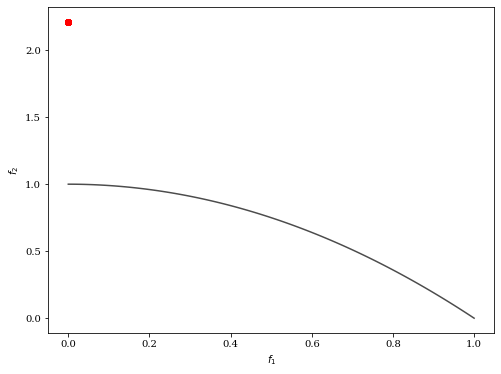

In [198]:
from pymoo.factory import get_problem, get_visualization, get_reference_directions
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.decomposition.perp_dist import PerpendicularDistance

problem = get_problem("zdt2")
n_obj = 2
algorithm = MOEAD_FPA(decomposition=Tchebicheff(), n_neighbours=20)
res = minimize(problem, algorithm, termination=('n_gen', 200))
print(res.exec_time)
if n_obj == 2:
    plot = Scatter()
    plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
    plot.add(res.F, color="red")
    plot.show()
else:
    plot = Scatter().add(res.F)
    plot.show()
# print(res.opt.get("F"))
    


### API